In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/3\ cource/CV/Birds\ Segmentation

/content/drive/.shortcut-targets-by-id/15p8MIxLnex3jZ4mZzZnJBcXEq_gbTBvF/3 cource/CV/Birds Segmentation


In [ ]:
"""AdamP for TensorFlow."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class AdamP(optimizer_v2.OptimizerV2):
    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 delta=0.1, wd_ratio=0.1, nesterov=False,
                 name='AdamP',
                 **kwargs):

        super(AdamP, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('delta', delta)
        self._set_hyper('wd_ratio', wd_ratio)

        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.nesterov = nesterov

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'p')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdamP, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        lr = apply_state[(var_device, var_dtype)]['lr_t']
        bias_correction1 = 1 - beta_1_power
        bias_correction2 = 1 - beta_2_power

        delta = array_ops.identity(self._get_hyper('delta', var_dtype))
        wd_ratio = array_ops.identity(self._get_hyper('wd_ratio', var_dtype))

        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                weight_decay=ops.convert_to_tensor_v2(self.weight_decay, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                delta=delta,
                wd_ratio=wd_ratio))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdamP, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values, use_locking=self._use_locking)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            perturb = (coefficients['beta_1_t'] * m_t + coefficients['one_minus_beta_1_t'] * grad) / denorm
        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay

        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])


    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):

        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))
        """
        Adam
        """
        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            p_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
            perturb = m_t * coefficients['beta_1_t']
            perturb = self._resource_scatter_add(perturb, indices, p_scaled_g_values) / denorm

        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay
        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])

    def _channel_view(self, x):
        return array_ops.reshape(x, shape=[x.shape[0], -1])

    def _layer_view(self, x):
        return array_ops.reshape(x, shape=[1, -1])

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        x_norm = math_ops.euclidean_norm(x, axis=-1) + eps
        y_norm = math_ops.euclidean_norm(y, axis=-1) + eps
        dot = math_ops.reduce_sum(x * y, axis=-1)

        return math_ops.abs(dot) / x_norm / y_norm

    def _projection(self, var, grad, perturb, delta, wd_ratio, eps):
        # channel_view
        cosine_sim = self._cosine_similarity(grad, var, eps, self._channel_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._channel_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(pred=cosine_max < compare_val,
                                            true_fn=lambda : self.channel_true_fn(var, perturb, wd_ratio, eps),
                                            false_fn=lambda : self.channel_false_fn(var, grad, perturb, delta, wd_ratio, eps))

        return perturb, wd

    def channel_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._channel_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._channel_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def channel_false_fn(self, var, grad, perturb, delta, wd_ratio, eps):
        cosine_sim = self._cosine_similarity(grad, var, eps, self._layer_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._layer_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(cosine_max < compare_val,
                                              true_fn=lambda : self.layer_true_fn(var, perturb, wd_ratio, eps),
                                              false_fn=lambda : self.identity_fn(perturb))

        return perturb, wd

    def layer_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._layer_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._layer_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def identity_fn(self, perturb):
        wd = 1.0

        return perturb, wd

    def get_config(self):
        config = super(AdamP, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'delta': self._serialize_hyperparameter('delta'),
            'wd_ratio': self._serialize_hyperparameter('wd_ratio'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            'nesterov': self.nesterov
        })
        return config

In [ ]:
def focal_loss(y, y_pred, gamma=2., alpha=0.25):
    from tensorflow.keras.backend import epsilon, clip, mean, sum, log, pow
    y_pred = clip(y_pred, epsilon(), 1)
    return mean(sum(alpha * (-y * log(y_pred) * pow(1.0 - y_pred, gamma)), axis=-1))


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_gt, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1)
        cross_entropy = -y_gt * K.log(y_pred)
        loss = alpha * K.pow(1. - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, MaxPooling2D, UpSampling2D, Activation, concatenate
from skimage import img_as_ubyte
from skimage.io import imread, imsave
from skimage.transform import resize
from os.path import join
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Activation, Dropout, Flatten, AveragePooling2D, ZeroPadding2D, Add, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.data import Dataset

from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow import keras

import random
import pandas as pd
import os
import numpy as np
import cv2

from skimage.io import imread
from skimage.transform import resize, rotate
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
IMAGESIZE = 288

In [ ]:
def BuildModel(input_height=IMAGESIZE, input_width=IMAGESIZE):
    def Link(name):
        conv = base_model.get_layer(name=name).output
        conv = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
        conv = BatchNormalization(momentum=0.9)(conv)
        return conv

    def Link1(name):
        return base_model.get_layer(name=name).output

    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(input_height, input_width, 3))

    last_trainable = 31
    for layer in base_model.layers[0:-last_trainable]:
        layer.trainable = False
    for layer in base_model.layers[-last_trainable:]:
        layer.trainable = True

    x = base_model.output    
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)

    up1 = concatenate([x, 
                       Link('block6h_add')], axis=-1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    x = BatchNormalization(momentum=0.9)(x)
    x = Conv2DTranspose(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    up2 = concatenate([UpSampling2D((2, 2))(x),
                       Link('block5f_add')], axis=-1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    x = BatchNormalization(momentum=0.9)(x)
    x = Conv2DTranspose(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
     
    up3 = concatenate([UpSampling2D((2, 2))(x), 
                     Link('block3d_add')], axis=-1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    x = BatchNormalization(momentum=0.9)(x)
    x = Conv2DTranspose(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)

    x = UpSampling2D((2, 2))(x)
    up4 = concatenate([x, Link('block2d_add')], axis=-1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Conv2DTranspose(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(2, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    output = tf.keras.activations.softmax(x, axis=-1)
    
    model = Model(base_model.input, output)
    return model

model = BuildModel() 

71688192/71686520 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import ReLU, Concatenate, Softmax
K.clear_session()
W_INIT='he_normal'

def conv_bn(x, f, k, padding='same'):
    x = Conv2D(f, k, padding=padding, kernel_initializer=W_INIT)(x)
    x = BatchNormalization(axis=3)(x)
    x = ReLU()(x)
    return x

def up_conv_bn(x, f, k, padding='same'):
    x = UpSampling2D()(x)
    x = Conv2DTranspose(f, k, padding=padding, kernel_initializer=W_INIT)(x)
    x = BatchNormalization(axis=3)(x)
    x = ReLU()(x)
    return x

def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    f1, f2, f3 = filters
    x = conv_bn(input_tensor, f1, (1, 1))
    x = conv_bn(x, f2, (kernel_size, kernel_size), 'same')
    x = Conv2D(f3, (1, 1), kernel_initializer=W_INIT, strides=strides)(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(f3, (1, 1), strides=strides, kernel_initializer=W_INIT)(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def u_block(x, f, name, base_model):
    y = base_model.get_layer(name).output
    y = conv_bn(y, 256, 1)
    f1 = f // 4
    x = Concatenate()([x, y])
    x = conv_block(x, 3, (f1, f1, f), strides=(1, 1))
    x = conv_block(x, 3, (f1, f1, f), strides=(1, 1))
    return x

def get_model():
    base_model = EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(288,288,3)
    )
    base_model.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    for layer in base_model.layers:
        if layer.name[:6] == 'block7':
            layer.trainable = True
    x = base_model.output
    x = conv_bn(x, 256, 1)
    x = conv_block(x, 3, (64, 64, 256), strides=(1, 1))
    
    x = u_block(x, 256, 'block6h_add', base_model)
    x = up_conv_bn(x, 256, 3)
    x = u_block(x, 256, 'block5f_add', base_model)
    x = up_conv_bn(x, 256, 3)
    x = u_block(x, 128, 'block3d_add', base_model)
    x = up_conv_bn(x, 128, 3)
    x = u_block(x, 64, 'block2d_add', base_model)
    x = up_conv_bn(x, 64, 3)

    x = UpSampling2D()(x)

    x = Conv2DTranspose(2, 3, padding='same', kernel_initializer=W_INIT)(x)
    x = BatchNormalization(axis=3)(x)
    x = Softmax()(x)

    return Model(base_model.input, x)
 
    
model = get_model()
#model.summary()

In [ ]:
from tensorflow.keras import backend as K
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_gt, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1)
        cross_entropy = -y_gt * K.log(y_pred)
        loss = alpha * K.pow(1. - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

def IoU_score(y_gt, y_pred):
    gt = y_gt[..., 1] > 0.5
    pred = y_pred[..., 1] > 0.5
    a = tf.reduce_sum(tf.cast(tf.math.logical_and(gt, pred), dtype='float32'))
    b = tf.reduce_sum(tf.cast(tf.math.logical_or(gt, pred), dtype='float32'))
    return  a / b

model.compile(
    optimizer=AdamP(learning_rate=0.0001, weight_decay=0.00001),
    loss=focal_loss(),
    metrics=[IoU_score]
)

In [ ]:
dir = 'data3'
X_train = np.load(join(dir, 'images_train.npy'))
y_train = np.load(join(dir, 'gt_train.npy'))
X_val = np.load(join(dir, 'images_test.npy'))
y_val = np.load(join(dir, 'gt_test.npy'))

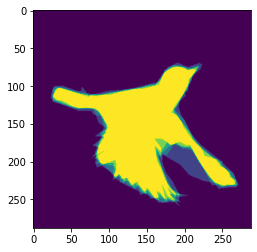

In [ ]:
plt.imshow(y_train[0])

In [ ]:
def get_iou(gt, pred):
    gt = gt[..., 0] > 0.5
    pred = pred[..., 0] > 0.5
    f = tf.reduce_sum(tf.cast(tf.math.logical_and(gt, pred), dtype='float32'))
    s = tf.reduce_sum(tf.cast(tf.math.logical_or(gt, pred), dtype='float32'))
    return f / s

In [ ]:
model = BuildModel()
opt = AdamP(learning_rate=0.0001, weight_decay=1e-5)
model.compile(optimizer=opt, loss=focal_loss, metrics=[get_iou])

KeyboardInterrupt: ignored

In [ ]:
if not os.path.isdir('checkpoints6/'):
    os.makedirs('checkpoints6/')
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoints = ModelCheckpoint('checkpoints6/model-{epoch:03d}-{val_loss:.5f}-{val_IoU_score:.5f}.hdf5', 
                              monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True)

In [ ]:
transform = A.Compose([
            A.Flip(p=0.5),
            A.OneOf(
                [A.RandomRotate90(p=0.8),
                A.Transpose(p=0.8),
                A.ShiftScaleRotate(p=0.8),
                A.VerticalFlip()],
                p=0.5
            ),
            A.OneOf(
                [A.JpegCompression(p=0.8),
                A.GaussNoise(p=0.8),
                A.Blur(p=0.8)],
                p = 0.5
            ),
            A.OneOf([
                A.OpticalDistortion(p=0.8),
                A.GridDistortion(p=0.8),
                A.IAAPiecewiseAffine(p=0.8),],
                p=0.5),
            A.OneOf([
                A.RGBShift(p=0.8),
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness()
            ], p=0.5),
            A.RandomBrightnessContrast(p=0.5),            
                ],
                p=1.0)
def Transform(image, mask):
    return transform(image=image, mask=mask)

In [ ]:
batch_cap = 32

def GeneratorData():
    size_batch = 0
    X = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3), dtype='float32')
    y = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 2), dtype='float32')
    idx = np.arange(len(X_train))
    while True:
        idx = np.random.permutation(idx)
        for i in idx:
            aug = Transform(X_train[i], y_train[i])
            x_one, y_one = aug['image'].astype(np.float32) / 255, aug['mask'].astype(np.float32) / 255 
            X[size_batch] = x_one
            y[size_batch] = np.stack((1 - y_one, y_one), axis=-1)
            size_batch += 1 
            if size_batch == batch_cap:
                yield preprocess_input(X), y
                size_batch = 0

def GeneratorDataVal():
    size_batch = 0
    X = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3), dtype='float32')
    y = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 2), dtype='float32')
    idx = np.arange(len(X_val))
    while True:
        idx = np.random.permutation(idx)
        for i in idx:
            x_one, y_one = X_val[i].astype(np.float32) / 255, y_val[i].astype(np.float32) / 255
            X[size_batch] = x_one
            y[size_batch] = np.stack((1 - y_one, y_one), axis=-1)
            size_batch += 1 
            if size_batch == batch_cap:
                yield preprocess_input(X), y
                size_batch = 0

In [ ]:
gen = GeneratorData()

In [ ]:
X, y = next(gen)

In [ ]:
y_pred = model.predict(X[:1])

In [ ]:
get_iou(y_pred[0], y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3028697>

In [ ]:
y_pred.shape

(1, 288, 288, 2)

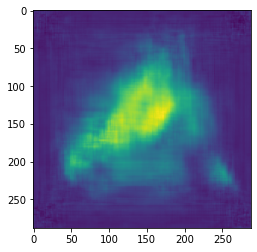

In [ ]:
plt.imshow(y_pred[0, ..., 0])

In [ ]:
batch_cap = 32
dataset_train = Dataset.from_generator(GeneratorData, 
                                       ('float32', 'float32'), 
                                       (tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 3]), 
                                        tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 2])), 
                                       args=[])
dataset_val = Dataset.from_generator(GeneratorDataVal, ('float32', 'float32'), 
                                     (tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 3]), 
                                      tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 2])), 
                                     args=[])

In [ ]:
history = model.fit(dataset_train, steps_per_epoch=100, epochs=500, validation_data=dataset_val, 
                    callbacks=checkpoints)

Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 0.0433 - IoU_score: 0.2517
Epoch 00001: saving model to checkpoints6/model-001-0.03900-0.00241.hdf5
100/100 [==============================] - 132s 1s/step - loss: 0.0433 - IoU_score: 0.2517 - val_loss: 0.0390 - val_IoU_score: 0.0024
Epoch 2/500
  3/100 [..............................] - ETA: 1:31 - loss: 0.0387 - IoU_score: 0.3088

KeyboardInterrupt: ignored

In [ ]:
y_train.shape

In [ ]:
model_my = BuildModel()

In [ ]:
model_my.load_weights('checkpoints6/s-model-015-0.9010-0.00487.hdf5')

In [ ]:
model_my.save('segmentation_model.hdf5')

In [ ]:
model = load_model('segmentation_model.hdf5')

In [ ]:
!python run.py 'tests' 

In [ ]:
val_size = len(image_res) - int(len(image_res) * 0.9)
validation_data=(preprocess_input(image_res[val_size:].astype(np.float32) / 255), gt_res[val_size:].astype(np.float32) / 255)

In [ ]:
!pip install --force-reinstall tensorflow_gpu=2.3.0

In [ ]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

In [ ]:
IMAGESIZE = 288

def GenerateFileNames(data_dir):
    images = []
    gt = []
    for image_dir in tqdm(os.listdir(os.path.join(data_dir, 'images'))):
        images_name = os.listdir(join(data_dir, 'images', image_dir))
        for im_name in images_name:
            images.append(join(data_dir, 'images', image_dir, im_name))
            gt.append(join(data_dir, 'gt', image_dir, im_name[:-4]+'.png'))
    return images, gt

def Upscale(image):
    return cv2.resize(image, (IMAGESIZE, IMAGESIZE),
                      interpolation=cv2.INTER_CUBIC)

def ReadAndResizeImage(image_path):
    image = cv2.imread(image_path)
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = np.stack((image, image, image), axis=-1)
    img = Upscale(image)
    return img

def ReadAndResizeImageGT(image_path):
    image = cv2.imread(image_path)
    if len(image.shape) == 3:
    	image = image[..., 0]
    img = Upscale(image)
    return img

def GenerateReaderTrain(path_data):
    images, gt = GenerateFileNames(path_data)
    batch_cap = 4
    size_batch = 0
    X = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3), dtype=np.float32)
    y = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 2), dtype=np.float32)
    for ind, file in tqdm(enumerate(images), desc='Reading images'):
        x_one, y_one = ReadAndResizeImage(file), ReadAndResizeImageGT(gt[ind])
        X[size_batch] = x_one
        y[size_batch] = np.stack((y_one, 1 - y_one), axis=-1)
        size_batch += 1 
        if size_batch == batch_cap:
            yield preprocess_input(X), y
            size_batch = 0

def train_segmentation_model(path_data):
    model = BuildModel()
    opt = AdamP(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4)
    model.compile(optimizer=opt, loss=focal_loss)
    dataset_train = Dataset.from_generator(GenerateReaderTrain, 
                                       ('float32', 'float32'), 
                                       (tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 3]), 
                                        tf.TensorShape([batch_cap, IMAGESIZE, IMAGESIZE, 2])), 
                                       args=[path_data])
    model.fit(dataset_train, steps_per_epoch=5, epochs=1)
    return model

def predict(model, filename):
    image = cv2.imread(filename)
    size = image.shape[:2]
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = np.stack((image, image, image), axis=-1)
    x = np.zeros((1, IMAGESIZE, IMAGESIZE, 3))
    x[0] = Upscale(image)
    y_pred = model.predict(x)[0, ..., 1]    
    y_pred = cv2.resize(y_pred, (size[1], size[0]), interpolation=cv2.INTER_CUBIC)
    return y_pred

In [ ]:
path = 'tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
y_pred = predict(model_my, path)

In [ ]:
!ls 'tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'

tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg


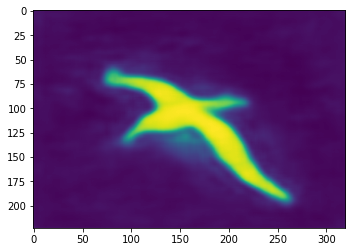

In [ ]:
plt.imshow(y_pred)

In [ ]:
y_pred = model_my.predict(X_train[:1])

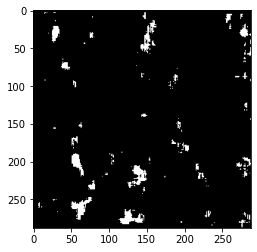

In [ ]:
plt.imshow(y_pred[0, ..., 0] > 0.5, 'gray')

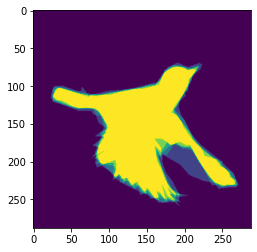

In [ ]:
plt.imshow(y_train[0])

In [ ]:
IoU_score(np.stack((y_train[0], 1 - y_train[0]), axis=-1), y_pred[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.9654345>

In [ ]:
np.stack((y_train[0], 1 - y_train[0]), axis=-1).shape

(288, 288, 2)

In [ ]:
y_pred[0].shape

(288, 288, 2)